In [1]:
import tensorflow as tf
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt

Instructions for updating:
Use tf.gfile.GFile.
images/2.jpg


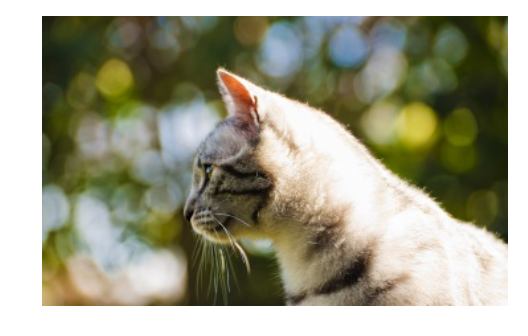

lynx, catamount (score = 0.50571)
Egyptian cat (score = 0.12768)
Siamese cat, Siamese (score = 0.09399)
snow leopard, ounce, Panthera uncia (score = 0.02541)
cougar, puma, catamount, mountain lion, painter, panther, Felis concolor (score = 0.02495)

images/4.jpg


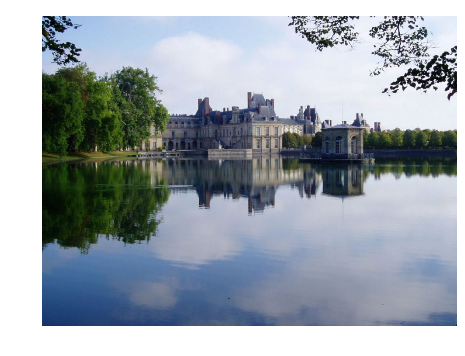

castle (score = 0.92613)
palace (score = 0.03120)
lakeside, lakeshore (score = 0.00464)
boathouse (score = 0.00315)
suspension bridge (score = 0.00154)

images/7.jpg


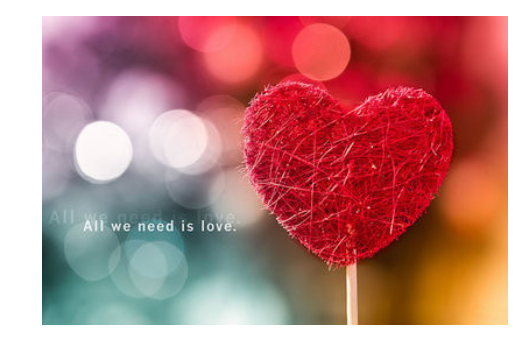

spider web, spider's web (score = 0.06752)
hook, claw (score = 0.02464)
pick, plectrum, plectron (score = 0.02392)
strawberry (score = 0.02276)
mitten (score = 0.01883)

images/8.jpg


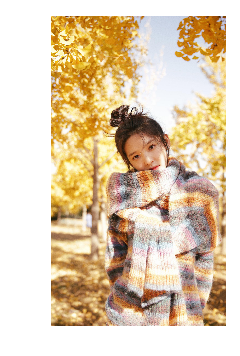

bonnet, poke bonnet (score = 0.27206)
fur coat (score = 0.13950)
swing (score = 0.07356)
stole (score = 0.05071)
cardigan (score = 0.01173)



In [2]:
class NodeLookup(object):
    def __init__(self):  
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'   
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

    def load(self, label_lookup_path, uid_lookup_path):
        # 加载分类字符串n********对应分类名称的文件
        #两个表数字对标识符，标识符对描述对象  映射
        # tensorflow读入文件
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        #一行一行读取数据
        for line in proto_as_ascii_lines :
            #去掉换行符
            line=line.strip('\n')
            #按照'\t'分割
            parsed_items = line.split('\t')
            #获取分类编号
            uid = parsed_items[0]
            #获取分类名称
            human_string = parsed_items[1]
            #字典
            #保存编号字符串n********与分类名称映射关系
            uid_to_human[uid] = human_string

        # 加载分类字符串n********对应分类编号1-1000的文件
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}
        for line in proto_as_ascii:
            if line.startswith('  target_class:'):
                #获取分类编号1-1000
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):
                #获取编号字符串n********
                target_class_string = line.split(': ')[1]
                #保存分类编号1-1000与编号字符串n********映射关系
                #[1：-2]即去掉引号
                node_id_to_uid[target_class] = target_class_string[1:-2]

        #建立分类编号1-1000对应分类名称的映射关系
        #两个字典之间的映射
        #建立新字典，即去掉中间映射
        node_id_to_name = {}
        for key, val in node_id_to_uid.items():
            #获取分类名称
            name = uid_to_human[val]
            #建立分类编号1-1000到分类名称的映射关系
            node_id_to_name[key] = name
        return node_id_to_name

    #传入分类编号1-1000返回分类名称
    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]


#创建一个图来存放google训练好的模型
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')


with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    #遍历目录
    for root,dirs,files in os.walk('images/'):
        for file in files:
            #载入图片
            image_data = tf.gfile.FastGFile(os.path.join(root,file), 'rb').read()
            predictions = sess.run(softmax_tensor,{'DecodeJpeg/contents:0': image_data})#图片格式是jpg格式
            predictions = np.squeeze(predictions)#把结果转为1维数据

            #打印图片路径及名称
            image_path = os.path.join(root,file)
            print(image_path)
            #显示图片
            img=Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

            #排序，概率从小到大，[-5:]取概率最大的五个值 [::-1]做倒序
            top_k = predictions.argsort()[-5:][::-1]
            node_lookup = NodeLookup()
            for node_id in top_k:     
                #获取分类名称
                human_string = node_lookup.id_to_string(node_id)
                #获取该分类的置信度
                score = predictions[node_id]
                print('%s (score = %.5f)' % (human_string, score))
            print()